# Supply Chain Shipment Price Data Analysis
## https://www.kaggle.com/divyeshardeshana/supply-chain-shipment-pricing-data

In [106]:
from utils import *
from fastai2.tabular.all import *
#from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype
from pandas.api.types import is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [107]:
path = Path.cwd()

In [108]:
df = pd.read_csv(path/'SCMS_Delivery_History_Dataset.csv', low_memory=False)

In [109]:
df.columns #No ordinal columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')

In [110]:
df.head()

,ID,Project Code,PQ #,PO / SO #,...,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,...,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,...,Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,...,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,...,Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,...,Yes,7590,45450.08,NaN


In [111]:
dep_var = 'Freight Cost (USD)'

In [15]:
fld = df['PQ First Sent to Client Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df['PQ First Sent to Client Date'] = fld = pd.to_datetime(fld, errors = 'coerce',infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'PQ First Sent to Client Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())

In [16]:
df['PQ First Sent to Client Date']

0              NaT
1              NaT
2              NaT
3              NaT
4              NaT
           ...    
10319   2014-10-16
10320   2014-10-24
10321   2014-08-12
10322   2015-07-01
10323   2014-10-16
Name: PQ First Sent to Client Date, Length: 10324, dtype: datetime64[ns]

In [17]:
fld = df['PO Sent to Vendor Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df['PO Sent to Vendor Date'] = fld = pd.to_datetime(fld, errors = 'coerce',infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'PO Sent to Vendor Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())

In [18]:
df['PO Sent to Vendor Date']

0       NaT
1       NaT
2       NaT
3       NaT
4       NaT
         ..
10319   NaT
10320   NaT
10321   NaT
10322   NaT
10323   NaT
Name: PO Sent to Vendor Date, Length: 10324, dtype: datetime64[ns]

In [19]:
fld = df['Scheduled Delivery Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df['Scheduled Delivery Date'] = fld = pd.to_datetime(fld, infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'Scheduled Delivery Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9

In [20]:
fld = df['Delivered to Client Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df['Delivered to Client Date'] = fld = pd.to_datetime(fld, infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'Delivered to Client Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9

In [21]:
fld = df['Delivery Recorded Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df['Delivery Recorded Date'] = fld = pd.to_datetime(fld, infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'Delivery Recorded Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9

In [22]:
' '.join(o for o in df.columns if o.startswith('Delivery Recorded'))

'Delivery Recorded Date Delivery Recorded Year Delivery Recorded Month Delivery Recorded Week Delivery Recorded Day Delivery Recorded Dayofweek Delivery Recorded Dayofyear Delivery Recorded Is_month_end Delivery Recorded Is_month_start Delivery Recorded Is_quarter_end Delivery Recorded Is_quarter_start Delivery Recorded Is_year_end Delivery Recorded Is_year_start Delivery Recorded Hour Delivery Recorded Minute Delivery Recorded Second Delivery Recorded Elapsed'

In [23]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       ...
       'Delivery Recorded Is_month_end', 'Delivery Recorded Is_month_start',
       'Delivery Recorded Is_quarter_end',
       'Delivery Recorded Is_quarter_start', 'Delivery Recorded Is_year_end',
       'Delivery Recorded Is_year_start', 'Delivery Recorded Hour',
       'Delivery Recorded Minute', 'Delivery Recorded Second',
       'Delivery Recorded Elapsed'],
      dtype='object', length=111)

In [118]:
procs = [Categorify, FillMissing]

In [119]:
def cont_cat_split(df, max_card=20, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for label in df:
        if label == dep_var: continue
        if df[label].dtype == int and df[label].unique().shape[0] > max_card or df[label].dtype == float:
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

In [120]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [121]:
cond = (df['Delivery Recorded Year']<2013) | (df['Delivery Recorded Month']<5)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

KeyError: 'Delivery Recorded Year'

In [28]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [30]:
len(to.train),len(to.valid)

(7878, 2446)

In [31]:
to.show(3)

,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Manufacturing Site,First Line Designation,Weight (Kilograms),PQ First Sent to Client Is_month_end,PQ First Sent to Client Is_month_start,PQ First Sent to Client Is_quarter_end,PQ First Sent to Client Is_quarter_start,PQ First Sent to Client Is_year_end,PQ First Sent to Client Is_year_start,PO Sent to Vendor Is_month_end,PO Sent to Vendor Is_month_start,PO Sent to Vendor Is_quarter_end,PO Sent to Vendor Is_quarter_start,PO Sent to Vendor Is_year_end,PO Sent to Vendor Is_year_start,Scheduled Delivery Is_month_end,Scheduled Delivery Is_month_start,Scheduled Delivery Is_quarter_end,Scheduled Delivery Is_quarter_start,Scheduled Delivery Is_year_end,Scheduled Delivery Is_year_start,Scheduled Delivery Hour,Scheduled Delivery Minute,Scheduled Delivery Second,Delivered to Client Is_month_end,Delivered to Client Is_month_start,Delivered to Client Is_quarter_end,Delivered to Client Is_quarter_start,Delivered to Client Is_year_end,Delivered to Client Is_year_start,Delivered to Client Hour,Delivered to Client Minute,Delivered to Client Second,Delivery Recorded Is_month_end,Delivery Recorded Is_month_start,Delivery Recorded Is_quarter_end,Delivery Recorded Is_quarter_start,Delivery Recorded Is_year_end,Delivery Recorded Is_year_start,Delivery Recorded Hour,Delivery Recorded Minute,Delivery Recorded Second,Line Item Insurance (USD)_na,PQ First Sent to Client Year_na,PQ First Sent to Client Month_na,PQ First Sent to Client Week_na,PQ First Sent to Client Day_na,PQ First Sent to Client Dayofweek_na,PQ First Sent to Client Dayofyear_na,PQ First Sent to Client Hour_na,PQ First Sent to Client Minute_na,PQ First Sent to Client Second_na,PO Sent to Vendor Year_na,PO Sent to Vendor Month_na,PO Sent to Vendor Week_na,PO Sent to Vendor Day_na,PO Sent to Vendor Dayofweek_na,PO Sent to Vendor Dayofyear_na,PO Sent to Vendor Hour_na,PO Sent to Vendor Minute_na,PO Sent to Vendor Second_na,ID,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD),PQ First Sent to Client Year,PQ First Sent to Client Month,PQ First Sent to Client Week,PQ First Sent to Client Day,PQ First Sent to Client Dayofweek,PQ First Sent to Client Dayofyear,PQ First Sent to Client Hour,PQ First Sent to Client Minute,PQ First Sent to Client Second,PO Sent to Vendor Year,PO Sent to Vendor Month,PO Sent to Vendor Week,PO Sent to Vendor Day,PO Sent to Vendor Dayofweek,PO Sent to Vendor Dayofyear,PO Sent to Vendor Hour,PO Sent to Vendor Minute,PO Sent to Vendor Second,Scheduled Delivery Year,Scheduled Delivery Month,Scheduled Delivery Week,Scheduled Delivery Day,Scheduled Delivery Dayofweek,Scheduled Delivery Dayofyear,Scheduled Delivery Elapsed,Delivered to Client Year,Delivered to Client Month,Delivered to Client Week,Delivered to Client Day,Delivered to Client Dayofweek,Delivered to Client Dayofyear,Delivered to Client Elapsed,Delivery Recorded Year,Delivery Recorded Month,Delivery Recorded Week,Delivery Recorded Day,Delivery Recorded Dayofweek,Delivery Recorded Dayofyear,Delivery Recorded Elapsed,Freight Cost (USD)
0,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,#na#,#na#,2006-06-02,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 Tests","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,#na#,Test kit,Ranbaxy Fine Chemicals LTD,Yes,13,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,False,False,False,False,False,False,0,0,0,False,False,False,False,False,False,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True

In [32]:
to.items.head(3)

,ID,Project Code,PQ #,PO / SO #,...,PO Sent to Vendor Dayofyear_na,PO Sent to Vendor Hour_na,PO Sent to Vendor Minute_na,PO Sent to Vendor Second_na
0,1.0,4,968,1325,...,2,2,2,2
1,3.0,63,968,337,...,2,2,2,2
2,4.0,4,968,845,...,2,2,2,2


In [33]:
(path/'to.pkl').save(to)

In [3]:
to = (path/'to.pkl').load()

In [4]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

### Decision Tree model

In [36]:
m = DecisionTreeRegressor(max_leaf_nodes=4) 
m.fit(xs, y);

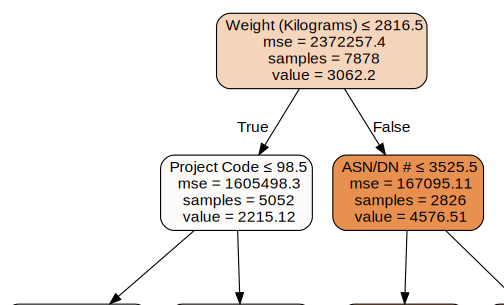

In [37]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

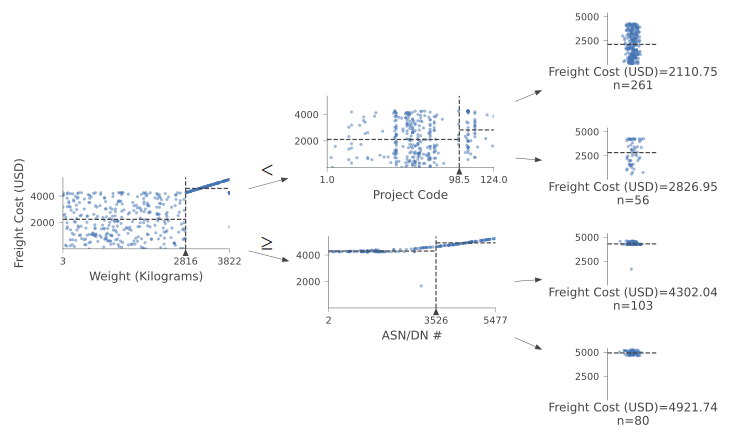

In [38]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [7]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [8]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [9]:
m_rmse(m, xs, y)

0.0

In [42]:
m_rmse(m, valid_xs, valid_y)

2419.296295

In [43]:
m.get_n_leaves(), len(xs)

(5623, 7878)

In [44]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(821.617348, 1985.602505)

In [45]:
m.get_n_leaves()

220

### Random Forest model

In [10]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):           
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [11]:
m = rf(xs, y);

In [12]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(575.63791, 2071.841542)

To see the impact of n_estimators, let's get the predictions from each individual tree in our forest (these are in the estimators_ attribute)

In [13]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

2071.841542

Since we have small training data (7878 rows), we check out of bag error also. i.e. w/o using validation set

In [14]:
r_mse(m.oob_prediction_, y)

917.632206

### Model Interpretation
1Q. How confident are we in our predictions using a particular row of data?

In [15]:
preds_std = preds.std(0)                

In [16]:
preds_std[:15]              

array([ 817.62281652, 1012.95078678, 1125.46561164, 1098.61803559,  780.52680595,  951.81520162,  872.16736136,  740.88718715,  735.99359985,  977.65833497,  965.36973774, 1041.56062898,
       1049.05543706,  808.19701822,  817.08969839])

1A. We are not confident since confidence in the predictions varies widely.

2Q. For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?¶

In [17]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [18]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
24,Weight (Kilograms),0.449177
23,First Line Designation,0.183817
3,ASN/DN #,0.026465
85,Line Item Quantity,0.022351
0,Project Code,0.018020
86,Line Item Value,0.017454
89,Line Item Insurance (USD),0.016719
2,PO / SO #,0.015182
83,ID,0.011668
87,Pack Price,0.011495


What are these features? 
* Weight - Weight of the shipment 
* First Line Designation - Designation of weight associated with agreegated freight cost on a shipment number 
* ASN/DN - Shipment Number 
* Project Code - Project code. 
* Line Item Quantity - Total quantity (packs) of commodity per line item 
* Line Item Insurance has higher feature importance than Line Item Value 
* PO/SO - Purchase order/Sales order 
* ID - Primary key indentifer of the line of data 
* Pack Price - Cost per pack (i.e. pack of 60 test kits)

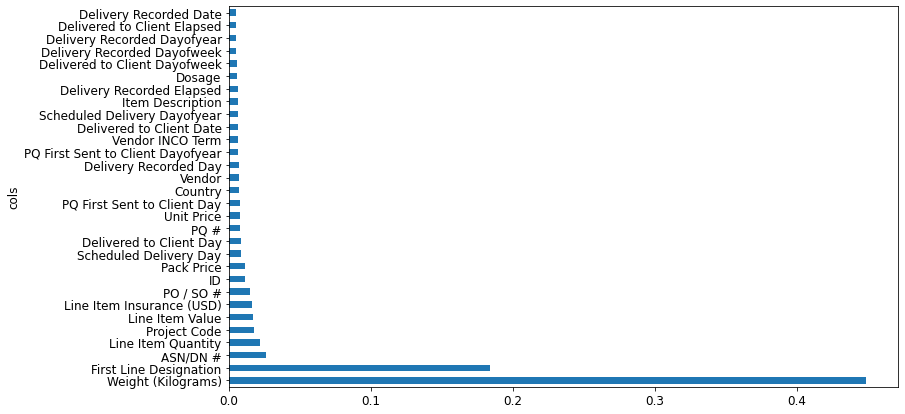

In [19]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

2A. Above are the important features.

Removing the variables of low importance We will look into columns with feature importance grater than 0.005 instead of original 130 columns

In [20]:
to_keep = fi[fi.imp>0.005].cols  
len(to_keep)                     

31

In [43]:
to_keep

24              Weight (Kilograms)
23          First Line Designation
3                         ASN/DN #
85              Line Item Quantity
0                     Project Code
                  ...             
126    Delivery Recorded Dayofweek
127    Delivery Recorded Dayofyear
121    Delivered to Client Elapsed
13          Delivery Recorded Date
22              Manufacturing Site
Name: cols, Length: 31, dtype: object

In [21]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y) 

(580.994042, 2146.555296)

Against error (572.775158, 2174.643936) for 130 columns

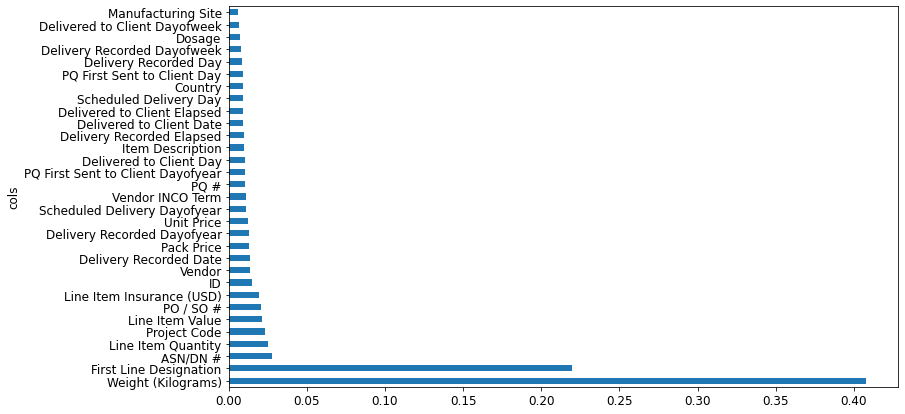

In [22]:
plot_fi(rf_feat_importance(m, xs_imp));

In [23]:
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    print(z.shape[0]+1)
    print(len(df.columns))
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, orientation='left', leaf_font_size=font_size)
    plt.show()

31
31


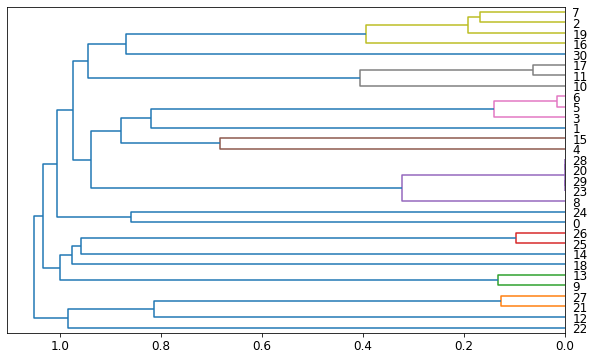

In [24]:
cluster_columns(xs_imp)

**ColumnNumber ColumnName**

* 1 ID
* 2 Project Code
* 3 PQ #
* 4 PO #
* 5 ASN/DN #
* 6 Country
* 7 Managed By
* 8 Fulfill Via
* 9 Vendor INCO Term
* 10 Shipment Mode
* 11 PQ First Sent to Client Date
* 12 PO Sent to Vendor Date
* 13 Scheduled Delivery Date
* 14 Delivered to Client Date
* 15 Delivery Recorded Date
* 16 Product Group
* 17 Sub Classification
* 18 Vendor
* 19 Item Description
* 20 Molecule/Test Type
* 21 Brand
* 22 Dosage
* 23 Dosage Form
* 24 Unit of Measure (Per Pack)
* 25 Line Item Quantity
* 26 Line Item Value
* 27 Pack Price
* 28 Unit Price
* 29 Manufacturing Site
* 30 First Line Designation
* 31 Weight (Kilograms)
* 32 Freight Cost (USD)
* 33 Line Item Insurance (USD)

In [27]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [28]:
get_oob(xs_imp)

0.633982984297612

 OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model.

In [34]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in ('Dosage', 'Pack Price', 'Unit Price', 'Manufacturing Site')}

{'Dosage': 0.6383357627537891,
 'Pack Price': 0.6355124677042917,
 'Unit Price': 0.6396422909619341,
 'Manufacturing Site': 0.6364363905593271}

Dropping these variables would make the model better since dropping each of them improves the OOB score. Lets see if the OOB score improves from 0.63398 by dropping all of them.

In [35]:
to_drop = ['Dosage', 'Pack Price', 'Unit Price', 'Manufacturing Site']
get_oob(xs_imp.drop(to_drop, axis=1))

0.6364743085439896

In [36]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [37]:
(path/'xs_final.pkl').save(xs_final)
(path/'valid_xs_final.pkl').save(valid_xs_final)

In [38]:
xs_final = (path/'xs_final.pkl').load()
valid_xs_final = (path/'valid_xs_final.pkl').load()

In [45]:
valid_xs_final.columns   #27 columns

Index(['Weight (Kilograms)', 'First Line Designation', 'ASN/DN #',
       'Line Item Quantity', 'Project Code', 'Line Item Value',
       'Line Item Insurance (USD)', 'PO / SO #', 'ID',
       'Scheduled Delivery Day', 'Delivered to Client Day', 'PQ #',
       'PQ First Sent to Client Day', 'Country', 'Vendor',
       'Delivery Recorded Day', 'PQ First Sent to Client Dayofyear',
       'Vendor INCO Term', 'Delivered to Client Date',
       'Scheduled Delivery Dayofyear', 'Item Description',
       'Delivery Recorded Elapsed', 'Delivered to Client Dayofweek',
       'Delivery Recorded Dayofweek', 'Delivery Recorded Dayofyear',
       'Delivered to Client Elapsed', 'Delivery Recorded Date'],
      dtype='object')

In [39]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(592.725192, 1938.870529)

This error is even better then (580.994042, 2146.555296) with 31 important features. Removing the four redundant variables, we now have 27 important features left

### Partial Dependence

We'd like to understand the relationship between these predictors and freight cost (USD). Lets check these one by one

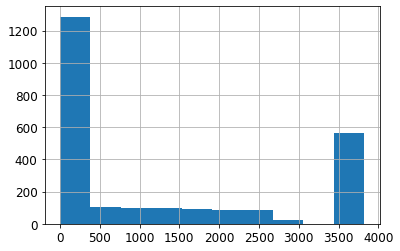

In [48]:
ax = valid_xs_final['Weight (Kilograms)'].hist()

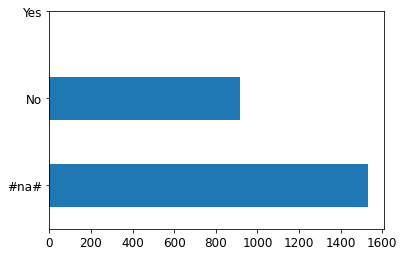

In [53]:
p = valid_xs_final['First Line Designation'].value_counts(sort=False).plot.barh()
c = to.classes['First Line Designation']
plt.yticks(range(len(c)), c);

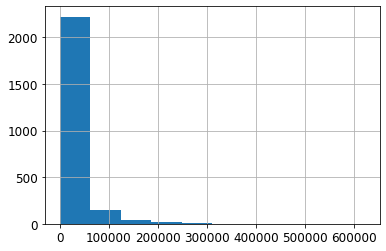

In [56]:
ax = valid_xs_final['Line Item Quantity'].hist()

In [72]:
#ax = valid_xs_final['Project Code'].hist()

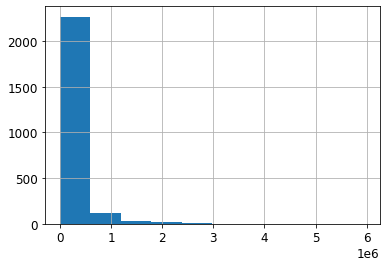

In [58]:
ax = valid_xs_final['Line Item Value'].hist()

In [80]:
#ax = valid_xs_final['Line Item Insurance (USD)'].hist()

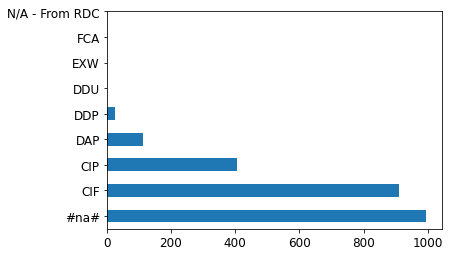

In [73]:
p = valid_xs_final['Vendor INCO Term'].value_counts(sort=True).plot.barh()
c = to.classes['Vendor INCO Term']
plt.yticks(range(len(c)), c);

In [75]:
#p = valid_xs_final['Country'].value_counts(sort=True).plot.barh()
#c = to.classes['Country']
#plt.yticks(range(len(c)), c);

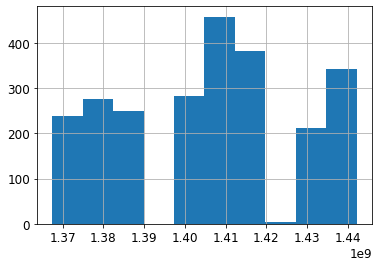

In [78]:
ax = valid_xs_final['Delivery Recorded Elapsed'].hist()

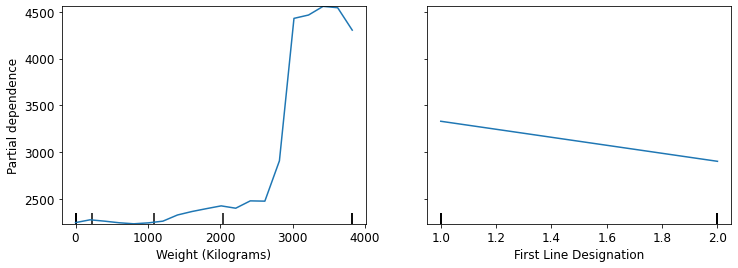

In [81]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['Weight (Kilograms)','First Line Designation'],
                        grid_resolution=20, ax=ax);

In [83]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [85]:
row = valid_xs_final.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [86]:
prediction[0], bias[0], contributions[0].sum()

(array([1790.33958576]), 3066.0500317339424, -1275.7104459724817)

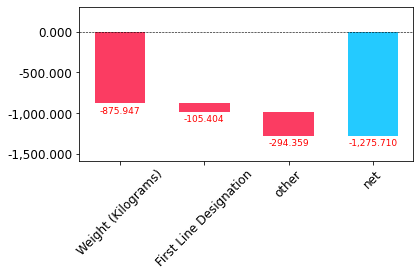

In [87]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

### Finding out of domain data

We don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set. To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance:

In [88]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
26,Delivery Recorded Date,0.470461
7,PO / SO #,0.207865
2,ASN/DN #,0.165755
18,Delivered to Client Date,0.094543
25,Delivered to Client Elapsed,0.048199
11,PQ #,0.012248


In [89]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('Delivery Recorded Date','PO / SO #','ASN/DN #', 'Delivered to Client Date', 'Delivered to Client Elapsed', 'PQ #' ):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 2105.873441
Delivery Recorded Date 1972.267562
PO / SO # 2056.985975
ASN/DN # 1938.76716
Delivered to Client Date 2044.923385
Delivered to Client Elapsed 2053.665658
PQ # 2144.018888


It looks like we should be able to remove Delivery Recorded Date, PO / SO #,  ASN/DN #, Delivered to Client Date and Delivered to Client Elapsed without losing any accuracy. Let's check:

In [90]:
time_vars = ['Delivery Recorded Date','PO / SO #','ASN/DN #', 'Delivered to Client Date', 'Delivered to Client Elapsed']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

2063.719545

Removing these variables has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand. 

In [92]:
valid_xs_time.columns

Index(['Weight (Kilograms)', 'First Line Designation', 'Line Item Quantity',
       'Project Code', 'Line Item Value', 'Line Item Insurance (USD)', 'ID',
       'Scheduled Delivery Day', 'Delivered to Client Day', 'PQ #',
       'PQ First Sent to Client Day', 'Country', 'Vendor',
       'Delivery Recorded Day', 'PQ First Sent to Client Dayofyear',
       'Vendor INCO Term', 'Scheduled Delivery Dayofyear', 'Item Description',
       'Delivery Recorded Elapsed', 'Delivered to Client Dayofweek',
       'Delivery Recorded Dayofweek', 'Delivery Recorded Dayofyear'],
      dtype='object')

### Neural Network Model

In [97]:
df_nn = pd.read_csv(path/'SCMS_Delivery_History_Dataset.csv', low_memory=False)

In [98]:
fld = df_nn['PQ First Sent to Client Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df_nn['PQ First Sent to Client Date'] = fld = pd.to_datetime(fld, errors = 'coerce',infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'PQ First Sent to Client Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df_nn[targ_pre + n] = getattr(fld.dt, n.lower())

In [99]:
fld = df_nn['PO Sent to Vendor Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df_nn['PO Sent to Vendor Date'] = fld = pd.to_datetime(fld, errors = 'coerce',infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'PO Sent to Vendor Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df_nn[targ_pre + n] = getattr(fld.dt, n.lower())

In [101]:
fld = df_nn['Scheduled Delivery Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df_nn['Scheduled Delivery Date'] = fld = pd.to_datetime(fld, infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'Scheduled Delivery Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df_nn[targ_pre + n] = getattr(fld.dt, n.lower())
df_nn[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9

In [103]:
fld = df_nn['Delivered to Client Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df_nn['Delivered to Client Date'] = fld = pd.to_datetime(fld, infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'Delivered to Client Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df_nn[targ_pre + n] = getattr(fld.dt, n.lower())
df_nn[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9

In [104]:
fld = df_nn['Delivery Recorded Date']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df_nn['Delivery Recorded Date'] = fld = pd.to_datetime(fld, infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'Delivery Recorded Date')
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
if time: attr = attr + ['Hour', 'Minute', 'Second']
for n in attr: df_nn[targ_pre + n] = getattr(fld.dt, n.lower())
df_nn[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9

In [112]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [113]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [114]:
cont_nn.append('Delivery Recorded Elapsed')
cat_nn.remove('Delivery Recorded Elapsed')

In [115]:
df_nn_final[cat_nn].nunique()

Weight (Kilograms)               4688
First Line Designation              2
Line Item Quantity               5065
Project Code                      142
Scheduled Delivery Day             31
Delivered to Client Day            31
PQ #                             1237
Country                            43
Vendor                             73
Delivery Recorded Day              31
Vendor INCO Term                    8
Scheduled Delivery Dayofyear      365
Item Description                  184
Delivered to Client Dayofweek       7
Delivery Recorded Dayofweek         7
Delivery Recorded Dayofyear       365
dtype: int64

Since there is no 'Year' variable left to differentiate old and new data, we split the 10324 rows dataset with 2000 rows in validation set and 8324 rows in training set i.e. approx 80%-20% ratio

In [151]:
train_idx = range(len(df_nn)-2446)
valid_idx = range(len(df_nn)-2446, len(df_nn))

splits = (list(train_idx),list(valid_idx))

In [152]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

KeyError: "['PQ First Sent to Client Dayofyear_na', 'PQ First Sent to Client Day_na', 'Line Item Insurance (USD)_na'] not in index"

In [153]:
dls = to_nn.dataloaders(1024)

In [154]:
y = to_nn.train.y
y.min(),y.max()

(0, 5661)

In [163]:
learn = tabular_learner(dls, y_range=(0,5662), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

In [164]:
learn.lr_find()

RuntimeError: expected dtype Float but got dtype Short

In [165]:
learn.fit_one_cycle(5, 1e-2)

RuntimeError: expected dtype Float but got dtype Short

In [166]:
preds,targs = learn.get_preds()
#r_mse(preds,targs) #Random forest accuracy 2063.719545
preds.shape

torch.Size([2000, 1])

In [159]:
learn.save('nn')

In [161]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

ValueError: operands could not be broadcast together with shapes (2000,) (2446,) 

In [167]:
r_mse(ens_preds,valid_y)

NameError: name 'ens_preds' is not defined